# 3.2 线性回归的从零开始实现

In [2]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

# 3.2.1 生成数据集

In [4]:
def synthetic_data(w, b, num_examples):  #@save
    """生成y=Xw+b+噪声"""
    X = torch.normal(0, 1, (num_examples, len(w)))       # X (n, len(w)) 正态分布随机矩阵
    y = torch.matmul(X, w) + b                           # y = X * w + b
    y += torch.normal(0, 0.01, y.shape)                  # y = X * w + b + e
    return X, y.reshape((-1, 1))

# 生成数据
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [5]:
print('features:', features[0], '\nlabel:', labels[0])

features: tensor([1.0216, 3.5977]) 
label: tensor([-5.9940])


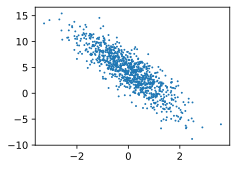

In [9]:
import matplotlib.pyplot as plt
plt.scatter(features[:, 1].detach().numpy(), labels.detach().numpy(), 1)

# 3.2.2 读取数据集

In [10]:
def data_iter(batch_size, features, labels):
    """将数据和标签随机分批"""
    num_examples = len(features)
    indices = list(range(num_examples))      # 随机排序序号
    random.shuffle(indices)
    # 分批
    for i in range(0, num_examples, batch_size):
        # 本批次序号
        batch_indices = torch.tensor(indices[i: min(i + batch_size, num_examples)])
        # yield为生成器，类似return，但调用函数时产生一个生成器，需要for去调用才能产生数据
        yield features[batch_indices], labels[batch_indices]

In [11]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[ 1.1778,  0.1396],
        [-0.5670, -1.1281],
        [-0.9014,  0.1266],
        [-0.5339, -0.5643],
        [ 1.6361,  0.6943],
        [ 0.6675, -0.4860],
        [ 2.1613, -0.3552],
        [-0.1059,  1.3930],
        [ 1.5915, -0.9551],
        [ 0.4326,  0.8832]]) 
 tensor([[ 6.0808],
        [ 6.8881],
        [ 1.9831],
        [ 5.0525],
        [ 5.1231],
        [ 7.1814],
        [ 9.7473],
        [-0.7488],
        [10.6348],
        [ 2.0573]])


# 3.2.3 初始化模型参数

In [12]:
# 初始参数
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

# 3.2.4 定义模型

In [13]:
def linreg(X, w, b):  #@save
    """线性回归模型"""
    return torch.matmul(X, w) + b

# 3.2.5 定义损失函数

In [14]:
def squared_loss(y_hat, y):  #@save
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

# 3.2.6 定义优化算法

In [15]:
# 基础sgd算法，输入参数，学习率和批次大小
def sgd(params, lr, batch_size): #@save
    """sgd随机梯度下降"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

# 3.2.7 训练

In [16]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)  # X和y的小批量损失
        # 因为l形状是(batch_size,1)，而不是一个标量。l中的所有元素被加到一起，
        # 并以此计算关于[w,b]的梯度
        l.sum().backward()
        sgd([w, b], lr, batch_size)  # 使用参数的梯度更新参数
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.045381
epoch 2, loss 0.000199
epoch 3, loss 0.000055


In [17]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([ 0.0003, -0.0005], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0007], grad_fn=<RsubBackward1>)


# 3.2.8 小结

# 3.2.9 练习

In [19]:
# 初始参数为0
w = torch.zeros(size=(2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

# 训练参数
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

# 训练
for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)  # X和y的小批量损失
        # 因为l形状是(batch_size,1)，而不是一个标量。l中的所有元素被加到一起，
        # 并以此计算关于[w,b]的梯度
        l.sum().backward()
        sgd([w, b], lr, batch_size)  # 使用参数的梯度更新参数
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.044939
epoch 2, loss 0.000194
epoch 3, loss 0.000055


1.权重初始化为0有时也可以